# Entraînement et Évaluation Complète du Modèle YOLOv8 pour la Détection de Mortalité Aviaire

**Objectif principal**  
Détecter automatiquement les oiseaux morts sur des images issues de sites sensibles (éoliennes, lignes électriques, routes, etc.) dans le cadre de la surveillance environnementale et de la réduction des impacts aviaires.

**Contenu du notebook**  
- Analyse exploratoire du dataset  
- Configuration et entraînement du modèle YOLOv8m  
- Évaluation quantitative et qualitative sur le jeu de test  
- Analyse des erreurs (Faux Positifs, Faux Négatifs, détections imprécises)  
- Visualisation des cas typiques (TP / FP / FN)

**Modèle final utilisé** : YOLOv8m (taille moyenne)  
**Taille des images d'entraînement** : 512 × 512  


## 1. Installation et Importation des Bibliothèques

In [1]:
# Installation des dépendances
!pip install ultralytics opencv-python matplotlib seaborn scikit-learn pandas numpy pillow -q

In [2]:
import os
import cv2
import yaml
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from PIL import Image
from ultralytics import YOLO
from sklearn.metrics import confusion_matrix, classification_report
import json
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

# Configuration pour des graphiques de haute qualité
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

print("Bibliothèques importées avec succès")

Bibliothèques importées avec succès


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
base_path = "/content/drive/MyDrive/projet_PIC/final_merged_dataset_v4"

##3. Création du fichier de configuration data.yaml

In [11]:
data_yaml = f"""
path: {base_path}
train: train/images
val: valid/images
test: test/images

nc: 1
names: ['dead_bird']
"""

with open("data.yaml", "w") as f:
    f.write(data_yaml)

print(data_yaml)



path: /content/drive/MyDrive/projet_PIC/final_merged_dataset_v4
train: train/images
val: valid/images
test: test/images

nc: 1
names: ['dead_bird']



## 4. Chargement et Entraînement du Modèle (historique)

In [9]:
model = YOLO("yolov8m.pt")


In [ ]:
model.summary()

In [ ]:
model.train(
    data="data.yaml",
    epochs=120,
    imgsz=512,
    batch=16,
    device="0",
    optimizer="AdamW",
    lr0=8e-4,
    weight_decay=5e-4,
    #AUGMENTATIONS
    mosaic=1.0,        # Activer pleinement pour diversité spatiale
    mixup=0.1,         # Ajouter pour réduire surapprentissage
    copy_paste=0.3,
    hsv_h=0.02,
    hsv_s=0.5,
    hsv_v=0.3,
    fliplr=0.5,
    flipud=0.5,        # Activer pour oiseaux (pas d'orientation fixe)
    degrees=15.0,      # Augmenter légèrement
    translate=0.2,     # Plus de variation spatiale
    scale=0.6,         # Plus de variation d'échelle
    shear=5.0,         # Ajouter du shearing
    #REGULARISATION
    dropout=0.1,       # Ajouter du dropout
    label_smoothing=0.05,
    #SMALL OBJECTS
    close_mosaic=20,   # Désactiver mosaic vers la fin
    #patience=25,
    project="/content/drive/MyDrive/avian_mortality4",
    name="yolo8m_80ep_p_r_"
)

## 5. Chargement du Meilleur Modèle Entraîné

In [12]:
# Charger le modèle entraîné
model_path = "/content/yolo8m_80ep_p_r_.pt"  # Modifiez selon votre chemin
model = YOLO(model_path)

print(f"✓ Modèle chargé depuis: {model_path}")
print(f"  Type de modèle: {model.model_name}")
print(f"  Nombre de classes: {len(model.names)}")
print(f"  Classes: {model.names}")

✓ Modèle chargé depuis: /content/yolo8m_80ep_p_r_.pt
  Type de modèle: /content/yolo8m_80ep_p_r_.pt
  Nombre de classes: 1
  Classes: {0: 'dead_bird'}


## 6. Évaluation sur le Jeu de Test

In [13]:
# Validation sur le jeu de test avec métriques détaillées
print("Évaluation en cours sur le jeu de test...\n")

results = model.val(
    data='data.yaml',
    split='test',
    imgsz=512,
    conf=0.2,        # Seuil de confiance
    iou=0.5,          # Seuil IoU pour NMS
    save_json=True,   # Sauvegarder les résultats en JSON
    save_hybrid=True, # Sauvegarder les labels hybrides
    plots=True,       # Générer les graphiques
    verbose=True
)

print("\n✓ Évaluation terminée")

Évaluation en cours sur le jeu de test...

WARNING ⚠️ 'save_hybrid' is deprecated and will be removed in the future.
Ultralytics 8.4.12 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 181.0±403.9 ms, read: 5.7±12.1 MB/s, size: 143.4 KB)
val: Scanning /content/drive/MyDrive/projet_PIC/final_merged_dataset_v4/test/labels.cache... 344 images, 212 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 344/344 43.7Mit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 22/22 6.7it/s 3.3s
                   all        344        132      0.684      0.508      0.549      0.209
Speed: 1.5ms preprocess, 3.1ms inference, 0.0ms loss, 0.7ms postprocess per image
Saving /content/runs/detect/val18/predictions.json...
Results saved to /content/runs/detect/val18

✓ Évaluation terminée


## 7. Extraction et Affichage des Métriques Principales

In [14]:
# Extraction des métriques clés
metrics = {
    'Precision': results.box.p[0] if hasattr(results.box, 'p') else results.box.mp,
    'Recall': results.box.r[0] if hasattr(results.box, 'r') else results.box.mr,
    'mAP@50': results.box.map50,
    'mAP@50-95': results.box.map,
    'F1-Score': 2 * (results.box.mp * results.box.mr) / (results.box.mp + results.box.mr) if (results.box.mp + results.box.mr) > 0 else 0
}

# Affichage formaté
print("="*60)
print("MÉTRIQUES DE PERFORMANCE SUR LE JEU DE TEST")
print("="*60)
for metric, value in metrics.items():
    print(f"{metric:20s}: {value:.4f} ({value*100:.2f}%)")
print("="*60)

# Créer un DataFrame pour export
metrics_df = pd.DataFrame([metrics])
metrics_df.to_csv('test_metrics.csv', index=False)
print("\n✓ Métriques sauvegardées dans 'test_metrics.csv'")

MÉTRIQUES DE PERFORMANCE SUR LE JEU DE TEST
Precision           : 0.6837 (68.37%)
Recall              : 0.5076 (50.76%)
mAP@50              : 0.5490 (54.90%)
mAP@50-95           : 0.2090 (20.90%)
F1-Score            : 0.5826 (58.26%)

✓ Métriques sauvegardées dans 'test_metrics.csv'


## 8. Analyse Détaillée des Prédictions

In [15]:
# Chemin vers les images de test
test_images_path = Path(base_path) / 'test' / 'images'
test_labels_path = Path(base_path) / 'test' / 'labels'

# Obtenir toutes les images de test
test_images = list(test_images_path.glob('*.jpg')) + list(test_images_path.glob('*.png'))
print(f"Nombre d'images dans le jeu de test: {len(test_images)}")

# Prédictions avec seuils variables pour analyse de sensibilité
confidence_thresholds = [0.1, 0.25, 0.5, 0.75, 0.9]
threshold_results = {}

print("\nAnalyse avec différents seuils de confiance...")
for conf_thresh in confidence_thresholds:
    pred_results = model.val(
        data='data.yaml',
        split='test',
        conf=conf_thresh,
        verbose=False
    )
    threshold_results[conf_thresh] = {
        'precision': pred_results.box.mp,
        'recall': pred_results.box.mr,
        'mAP50': pred_results.box.map50,
        'mAP50-95': pred_results.box.map
    }
    print(f"  Seuil {conf_thresh:.2f}: Precision={pred_results.box.mp:.3f}, Recall={pred_results.box.mr:.3f}")

print("\n✓ Analyse multi-seuils terminée")

Nombre d'images dans le jeu de test: 344

Analyse avec différents seuils de confiance...
Ultralytics 8.4.12 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
val: Fast image access ✅ (ping: 0.6±0.3 ms, read: 43.6±26.1 MB/s, size: 73.4 KB)
val: Scanning /content/drive/MyDrive/projet_PIC/final_merged_dataset_v4/test/labels.cache... 344 images, 212 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 344/344 131.2Mit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 22/22 5.0it/s 4.4s
                   all        344        132      0.603        0.5      0.502      0.189
Speed: 2.2ms preprocess, 3.6ms inference, 0.0ms loss, 1.4ms postprocess per image
Results saved to /content/runs/detect/val19
  Seuil 0.10: Precision=0.603, Recall=0.500
Ultralytics 8.4.12 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
val: Fast image access ✅ (ping: 0.5±0.2 ms, read: 46.5±14.5 MB/s, size: 105.5 KB)
val: Scanning /content/

## 9. Génération des Graphiques

In [16]:
# Configuration pour des graphiques de qualité publication
plt.rcParams['figure.dpi'] = 150
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.size'] = 10
plt.rcParams['font.family'] = 'serif'

# Créer un dossier pour les résultats
results_dir = Path('evaluation_results')
results_dir.mkdir(exist_ok=True)

print("Génération des graphiques...")

Génération des graphiques...


### 9.1 Analyse détaillée image par image


In [17]:
detection_stats = {
    'total_images': 0,
    'images_with_detections': 0,
    'images_with_ground_truth': 0,
    'true_positives': 0,
    'false_positives': 0,
    'false_negatives': 0,
    'total_detections': 0,
    'total_ground_truth': 0,
    'confidence_scores': []
}

print("Analyse des détections par image...\n")

for img_path in test_images[:]:  # Analyser tt images (ajustez selon besoin)
    detection_stats['total_images'] += 1

    # Prédiction
    pred = model.predict(source=str(img_path), conf=0.25, verbose=False)[0]

    # Vérifier les labels ground truth
    label_path = test_labels_path / (img_path.stem + '.txt')
    has_ground_truth = label_path.exists() and label_path.stat().st_size > 0

    if has_ground_truth:
        detection_stats['images_with_ground_truth'] += 1
        with open(label_path, 'r') as f:
            detection_stats['total_ground_truth'] += len(f.readlines())

    # Analyser les détections
    num_detections = len(pred.boxes)
    detection_stats['total_detections'] += num_detections

    if num_detections > 0:
        detection_stats['images_with_detections'] += 1
        for box in pred.boxes:
            confidence = float(box.conf[0])
            detection_stats['confidence_scores'].append(confidence)

# Calculer les statistiques
print("="*60)
print("STATISTIQUES DE DÉTECTION")
print("="*60)
print(f"Images analysées: {detection_stats['total_images']}")
print(f"Images avec ground truth: {detection_stats['images_with_ground_truth']}")
print(f"Images avec détections: {detection_stats['images_with_detections']}")
print(f"Total détections: {detection_stats['total_detections']}")
print(f"Total ground truth: {detection_stats['total_ground_truth']}")
if detection_stats['confidence_scores']:
    print(f"Confiance moyenne: {np.mean(detection_stats['confidence_scores']):.3f}")
    print(f"Confiance médiane: {np.median(detection_stats['confidence_scores']):.3f}")
    print(f"Confiance min/max: {np.min(detection_stats['confidence_scores']):.3f} / {np.max(detection_stats['confidence_scores']):.3f}")
print("="*60)

Analyse des détections par image...

STATISTIQUES DE DÉTECTION
Images analysées: 344
Images avec ground truth: 132
Images avec détections: 90
Total détections: 114
Total ground truth: 132
Confiance moyenne: 0.607
Confiance médiane: 0.621
Confiance min/max: 0.254 / 0.995


### 9.2 Courbe Precision-Recall selon le seuil de confiance


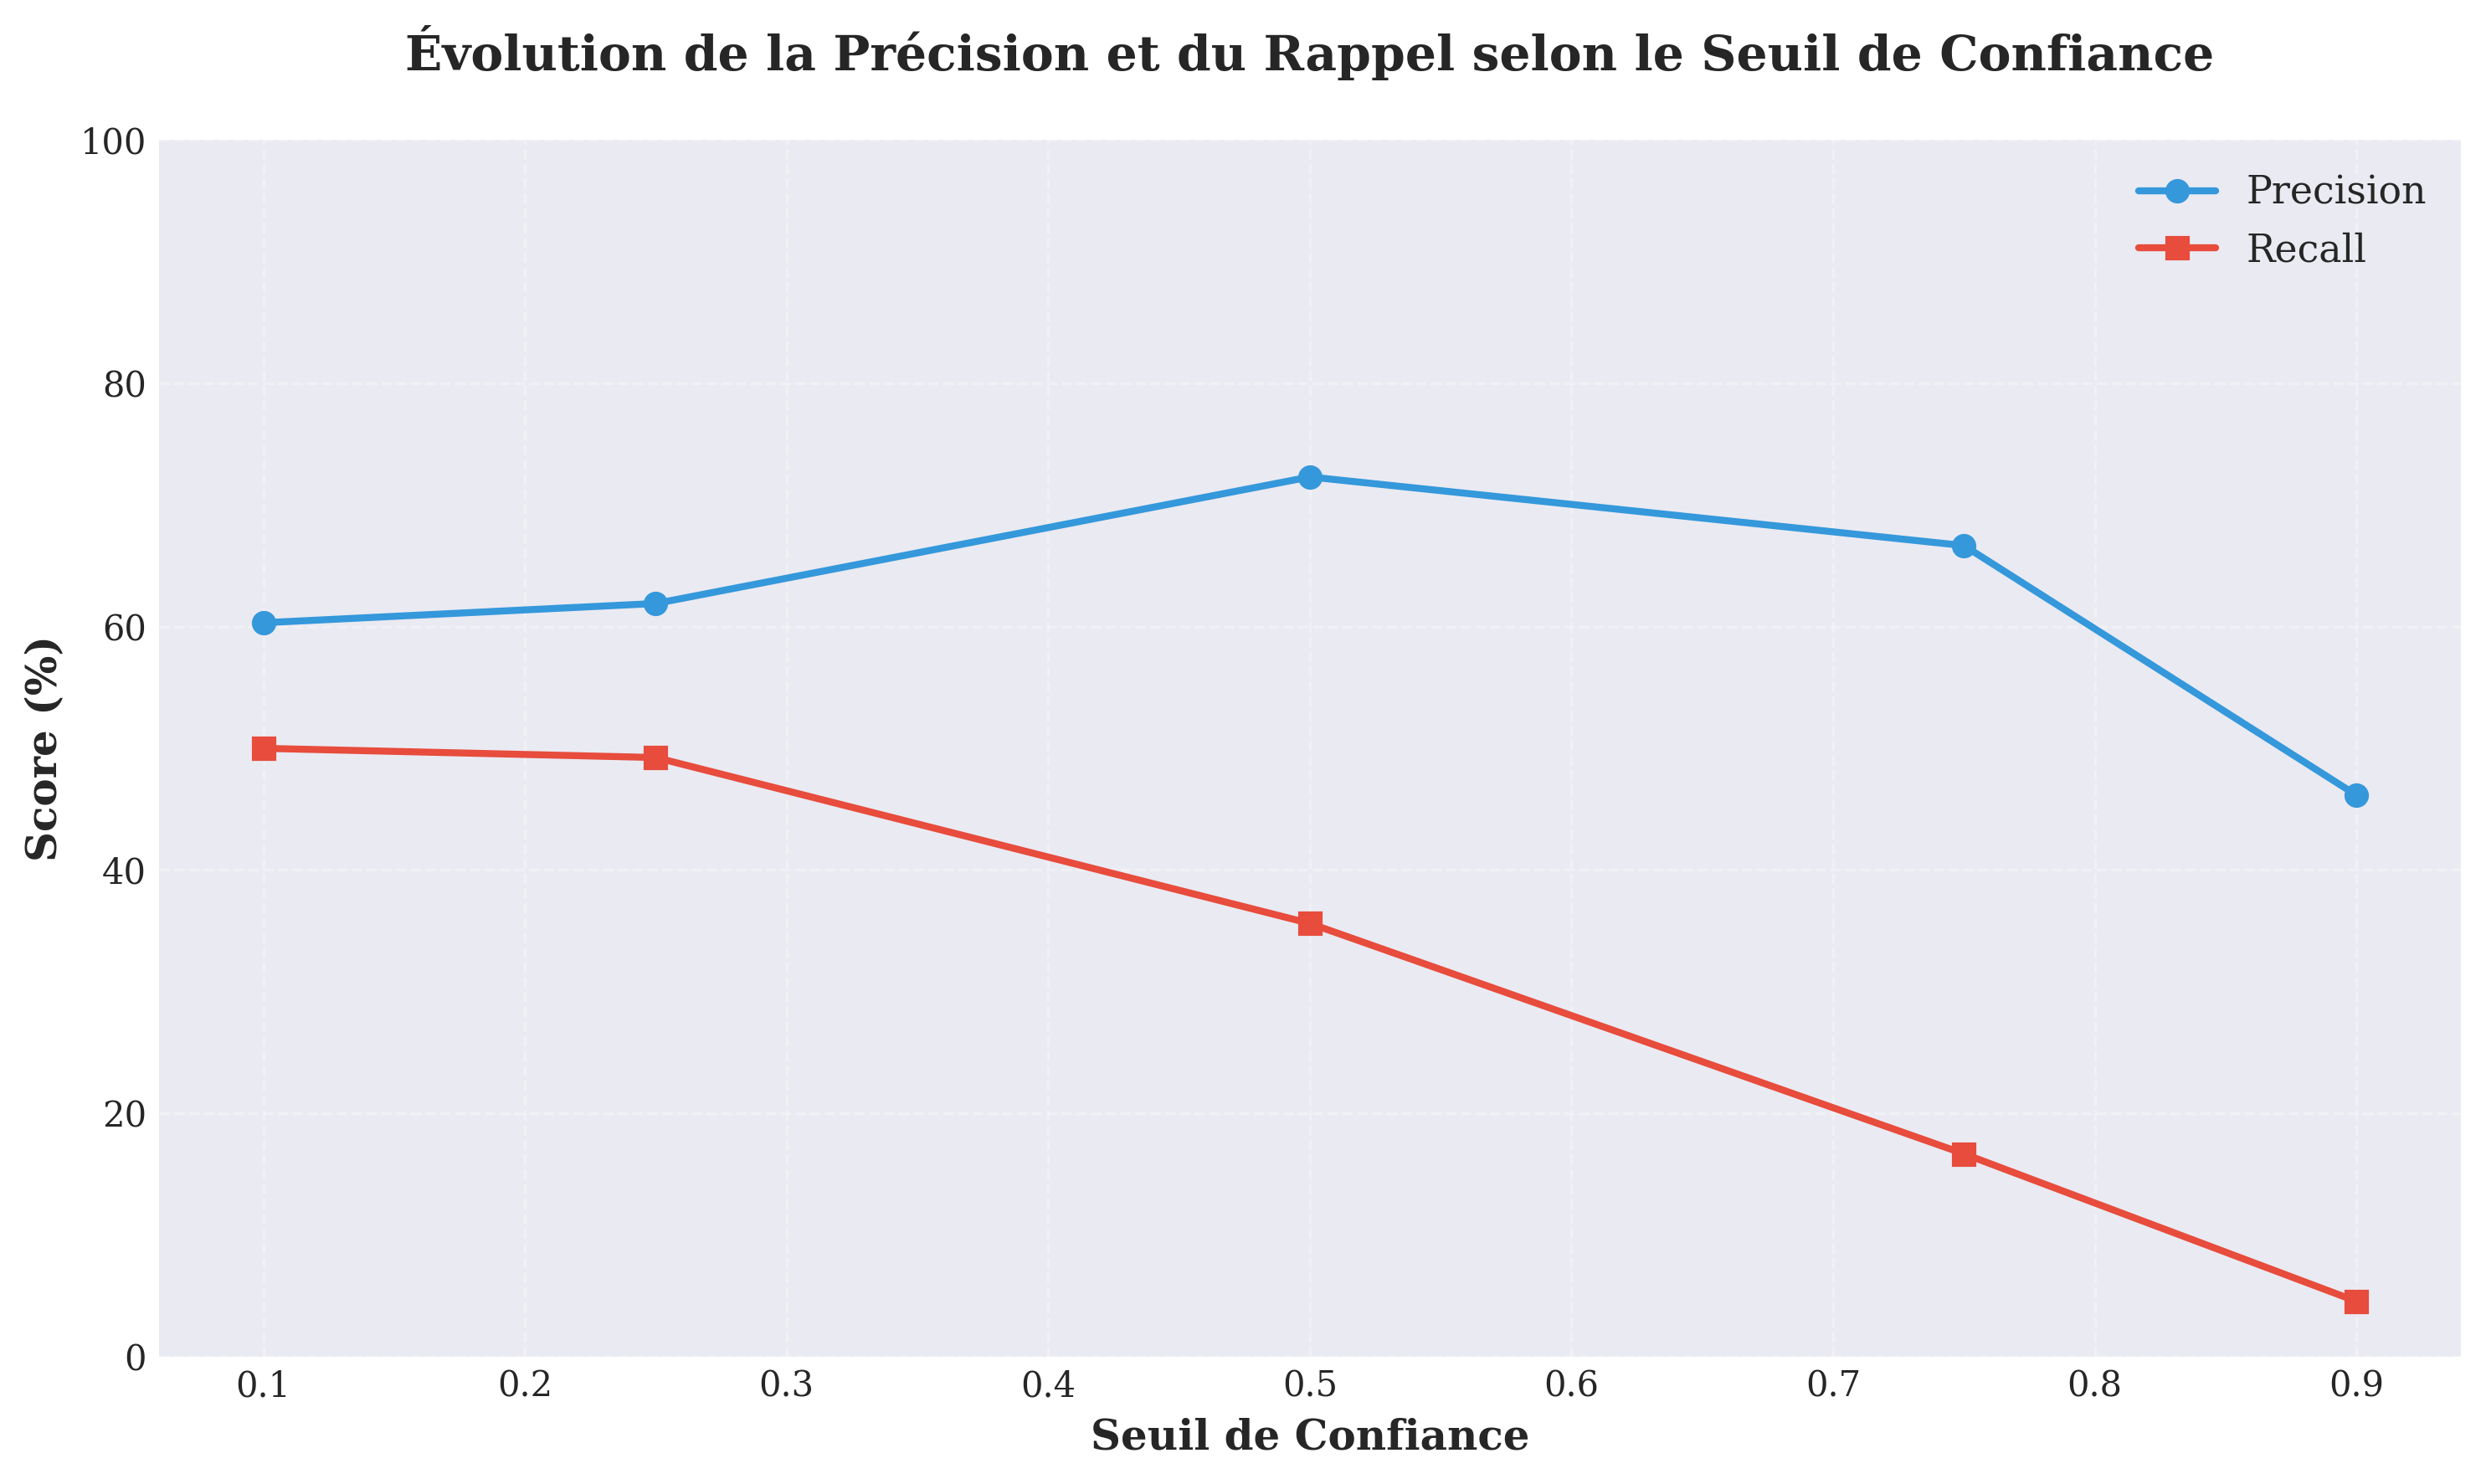

✓ Courbe Precision-Recall sauvegardée


In [18]:
fig, ax = plt.subplots(figsize=(10, 6))

thresholds = list(threshold_results.keys())
precisions = [threshold_results[t]['precision'] * 100 for t in thresholds]
recalls = [threshold_results[t]['recall'] * 100 for t in thresholds]

ax.plot(thresholds, precisions, marker='o', linewidth=2, label='Precision', color='#3498db')
ax.plot(thresholds, recalls, marker='s', linewidth=2, label='Recall', color='#e74c3c')
ax.set_xlabel('Seuil de Confiance', fontsize=12, fontweight='bold')
ax.set_ylabel('Score (%)', fontsize=12, fontweight='bold')
ax.set_title('Évolution de la Précision et du Rappel selon le Seuil de Confiance',
             fontsize=14, fontweight='bold', pad=20)
ax.legend(fontsize=11, loc='best')
ax.grid(True, alpha=0.3, linestyle='--')
ax.set_ylim(0, 100)

plt.tight_layout()
plt.savefig(results_dir / 'precision_recall_vs_threshold.png', bbox_inches='tight')
plt.show()
print("✓ Courbe Precision-Recall sauvegardée")

### 9.3 Distribution des scores de confiance


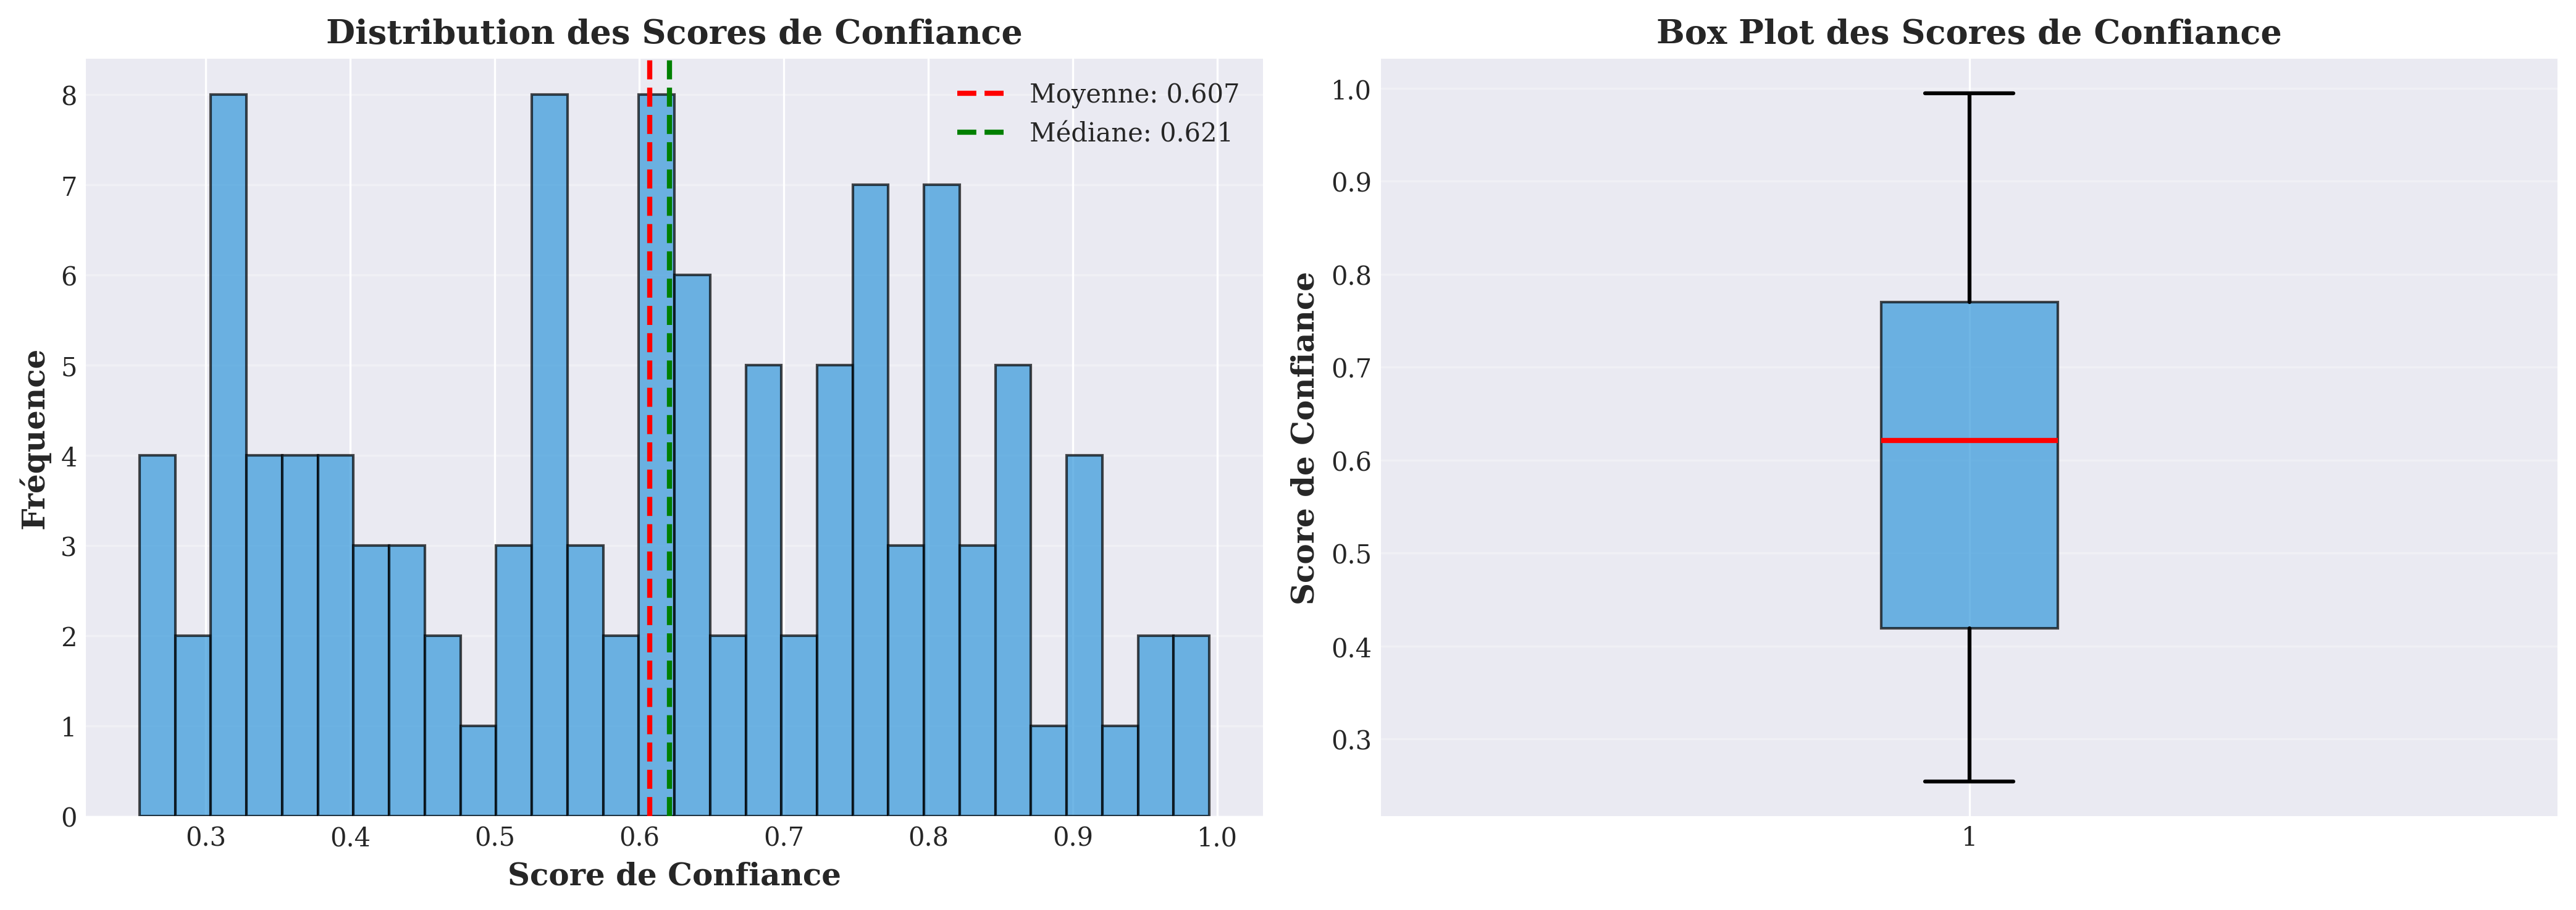

✓ Distribution des confidences sauvegardée


In [19]:
if detection_stats['confidence_scores']:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # Histogramme
    ax1.hist(detection_stats['confidence_scores'], bins=30, color='#3498db', alpha=0.7, edgecolor='black')
    ax1.axvline(np.mean(detection_stats['confidence_scores']), color='red',
                linestyle='--', linewidth=2, label=f'Moyenne: {np.mean(detection_stats["confidence_scores"]):.3f}')
    ax1.axvline(np.median(detection_stats['confidence_scores']), color='green',
                linestyle='--', linewidth=2, label=f'Médiane: {np.median(detection_stats["confidence_scores"]):.3f}')
    ax1.set_xlabel('Score de Confiance', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Fréquence', fontsize=12, fontweight='bold')
    ax1.set_title('Distribution des Scores de Confiance', fontsize=13, fontweight='bold')
    ax1.legend(fontsize=10)
    ax1.grid(axis='y', alpha=0.3)

    # Box plot
    ax2.boxplot(detection_stats['confidence_scores'], vert=True, patch_artist=True,
                boxprops=dict(facecolor='#3498db', alpha=0.7),
                medianprops=dict(color='red', linewidth=2),
                whiskerprops=dict(linewidth=1.5),
                capprops=dict(linewidth=1.5))
    ax2.set_ylabel('Score de Confiance', fontsize=12, fontweight='bold')
    ax2.set_title('Box Plot des Scores de Confiance', fontsize=13, fontweight='bold')
    ax2.grid(axis='y', alpha=0.3)

    plt.tight_layout()
    plt.savefig(results_dir / 'confidence_distribution.png', bbox_inches='tight')
    plt.show()
    print("✓ Distribution des confidences sauvegardée")

### 9.4 Graphique radar des métriques


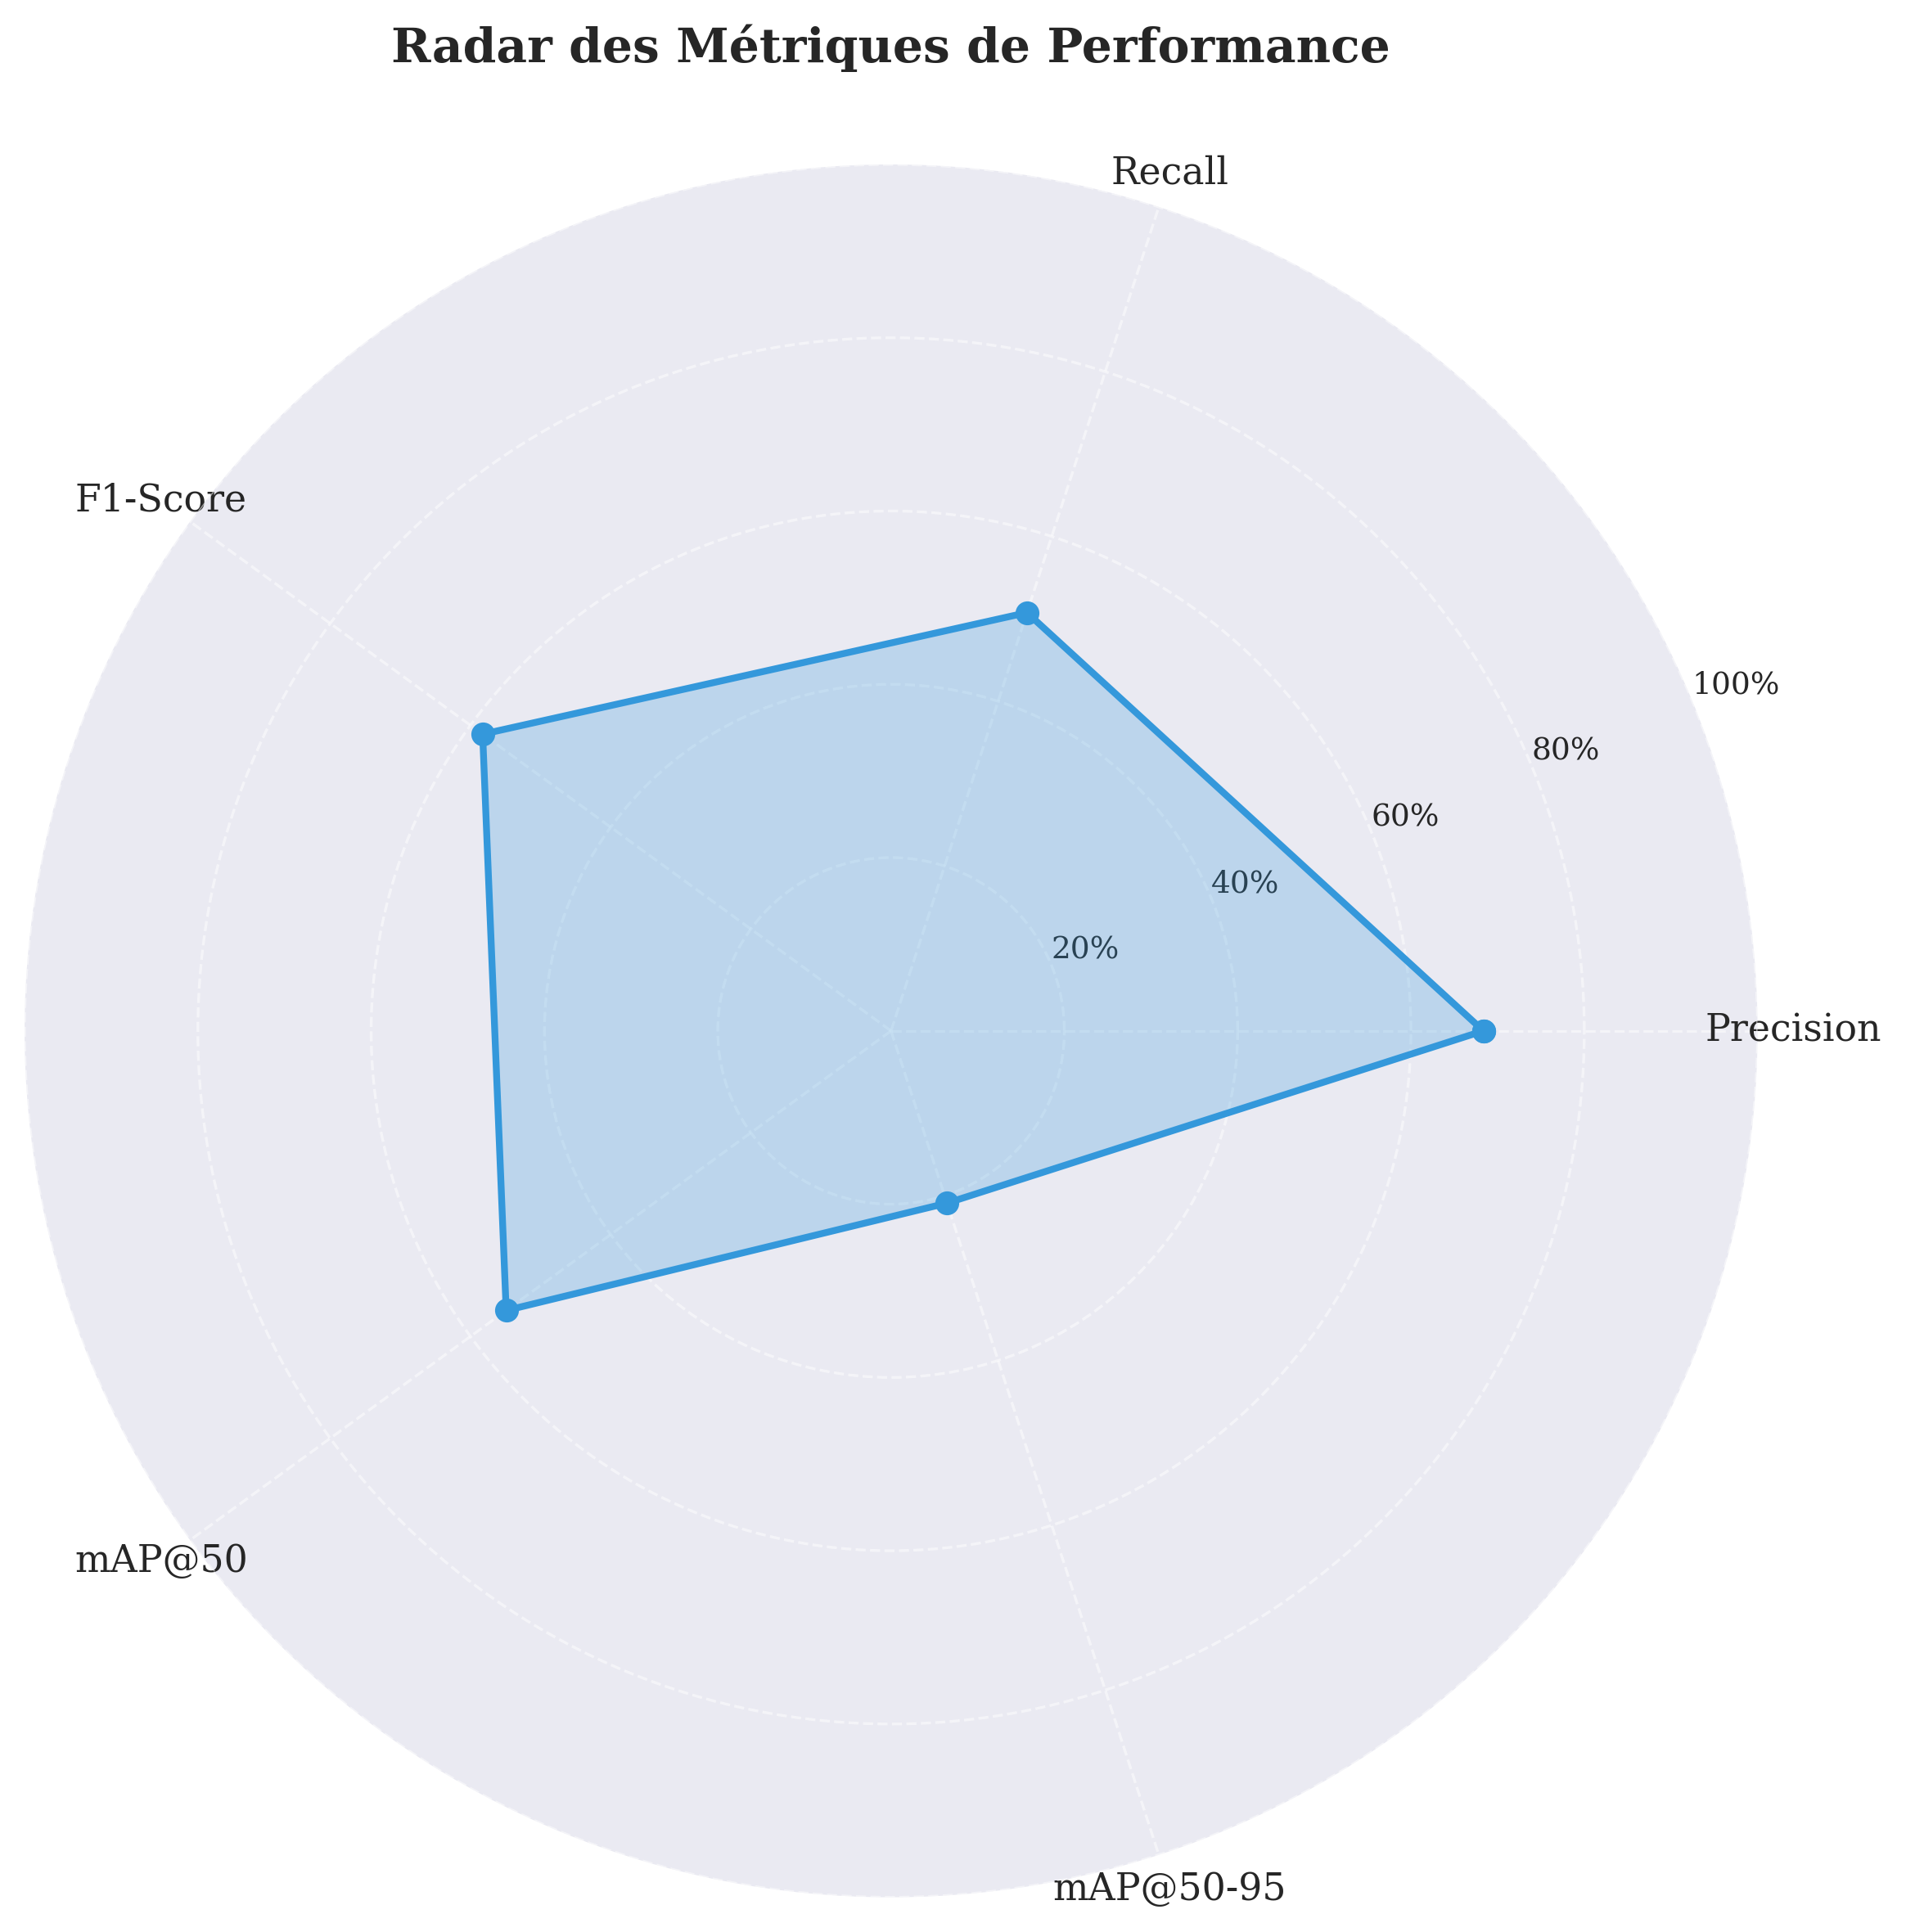

✓ Graphique radar sauvegardé


In [20]:
from math import pi

categories = ['Precision', 'Recall', 'F1-Score', 'mAP@50', 'mAP@50-95']
values = [
    metrics['Precision'] * 100,
    metrics['Recall'] * 100,
    metrics['F1-Score'] * 100,
    metrics['mAP@50'] * 100,
    metrics['mAP@50-95'] * 100
]

# Nombre de variables
N = len(categories)
angles = [n / float(N) * 2 * pi for n in range(N)]
values += values[:1]  # Fermer le cercle
angles += angles[:1]

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(projection='polar'))
ax.plot(angles, values, 'o-', linewidth=2, color='#3498db')
ax.fill(angles, values, alpha=0.25, color='#3498db')
ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories, fontsize=11)
ax.set_ylim(0, 100)
ax.set_yticks([20, 40, 60, 80, 100])
ax.set_yticklabels(['20%', '40%', '60%', '80%', '100%'], fontsize=9)
ax.grid(True, linestyle='--', alpha=0.5)
ax.set_title('Radar des Métriques de Performance', fontsize=14, fontweight='bold', pad=30)

plt.tight_layout()
plt.savefig(results_dir / 'metrics_radar.png', bbox_inches='tight')
plt.show()
print("✓ Graphique radar sauvegardé")

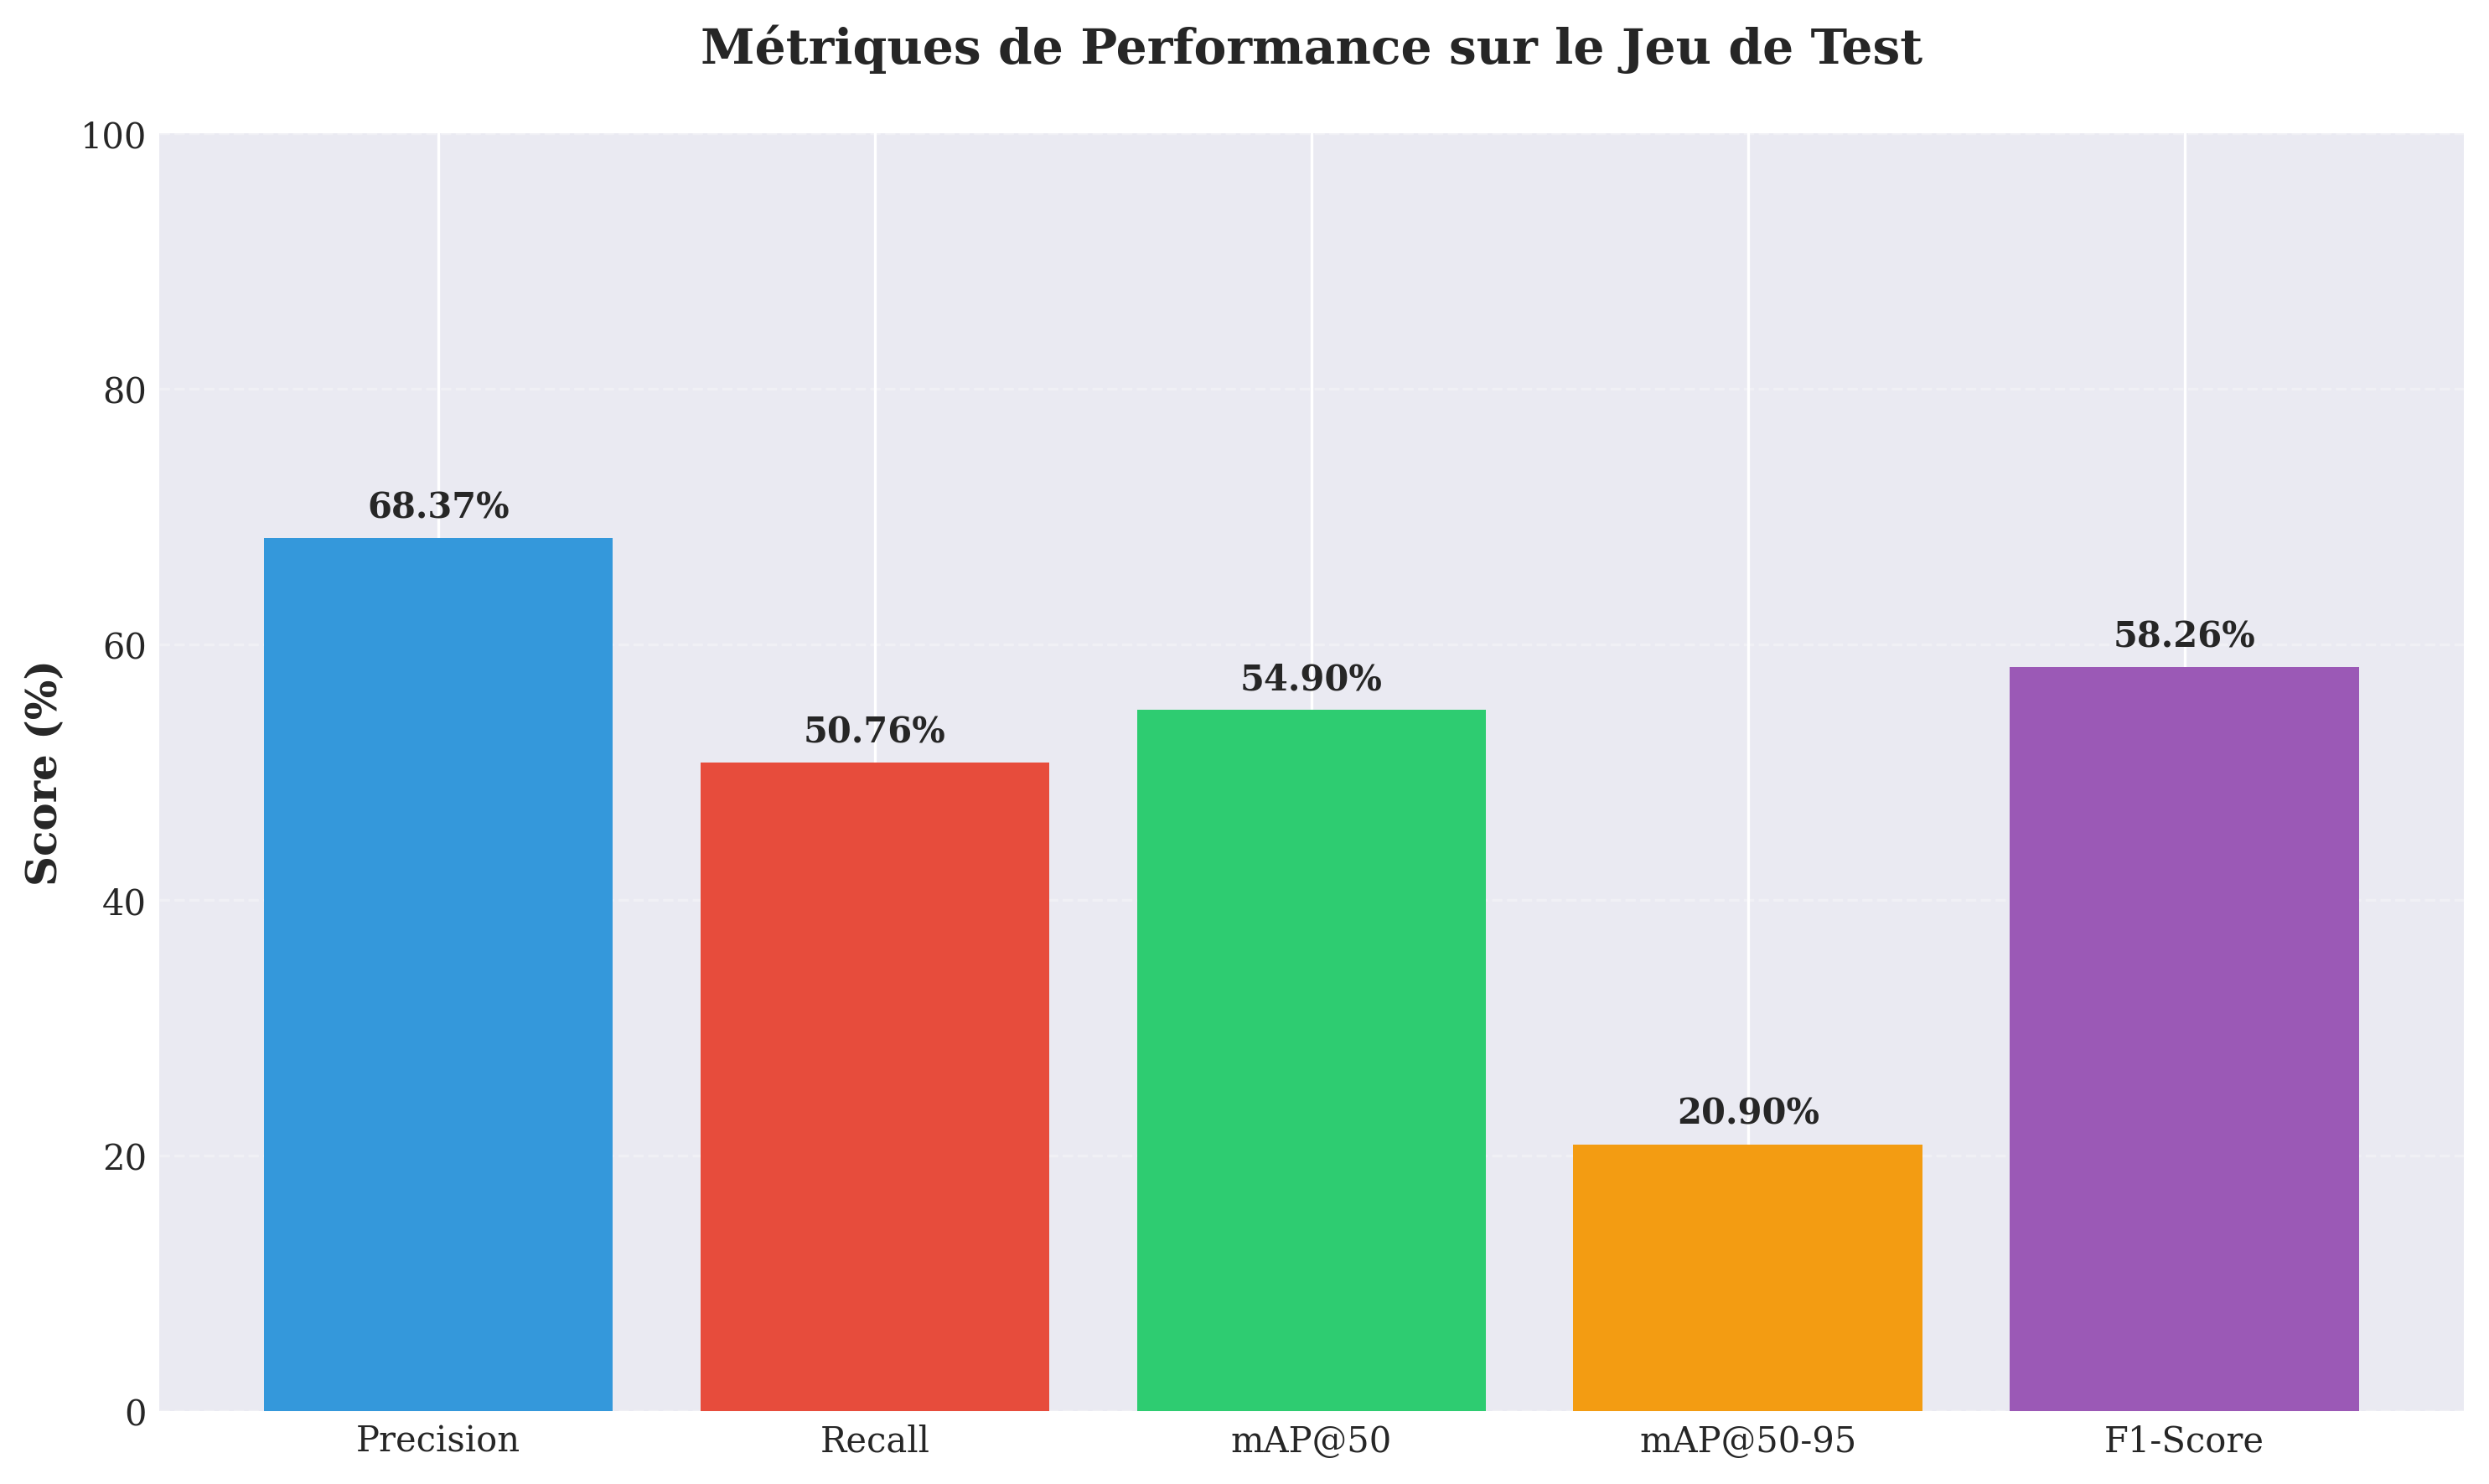

✓ Graphique des métriques sauvegardé


In [21]:
# 9.5 Graphique des métriques principales
fig, ax = plt.subplots(figsize=(10, 6))
metric_names = list(metrics.keys())
metric_values = [metrics[m] * 100 for m in metric_names]

bars = ax.bar(metric_names, metric_values, color=['#3498db', '#e74c3c', '#2ecc71', '#f39c12', '#9b59b6'])
ax.set_ylabel('Score (%)', fontsize=12, fontweight='bold')
ax.set_title('Métriques de Performance sur le Jeu de Test', fontsize=14, fontweight='bold', pad=20)
ax.set_ylim(0, 100)
ax.grid(axis='y', alpha=0.3, linestyle='--')

# Ajouter les valeurs au-dessus des barres
for bar, value in zip(bars, metric_values):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 1,
            f'{value:.2f}%', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig(results_dir / 'metrics_barplot.png', bbox_inches='tight')
plt.show()
print("✓ Graphique des métriques sauvegardé")

## 10. Visualisation d'Exemples de Prédictions

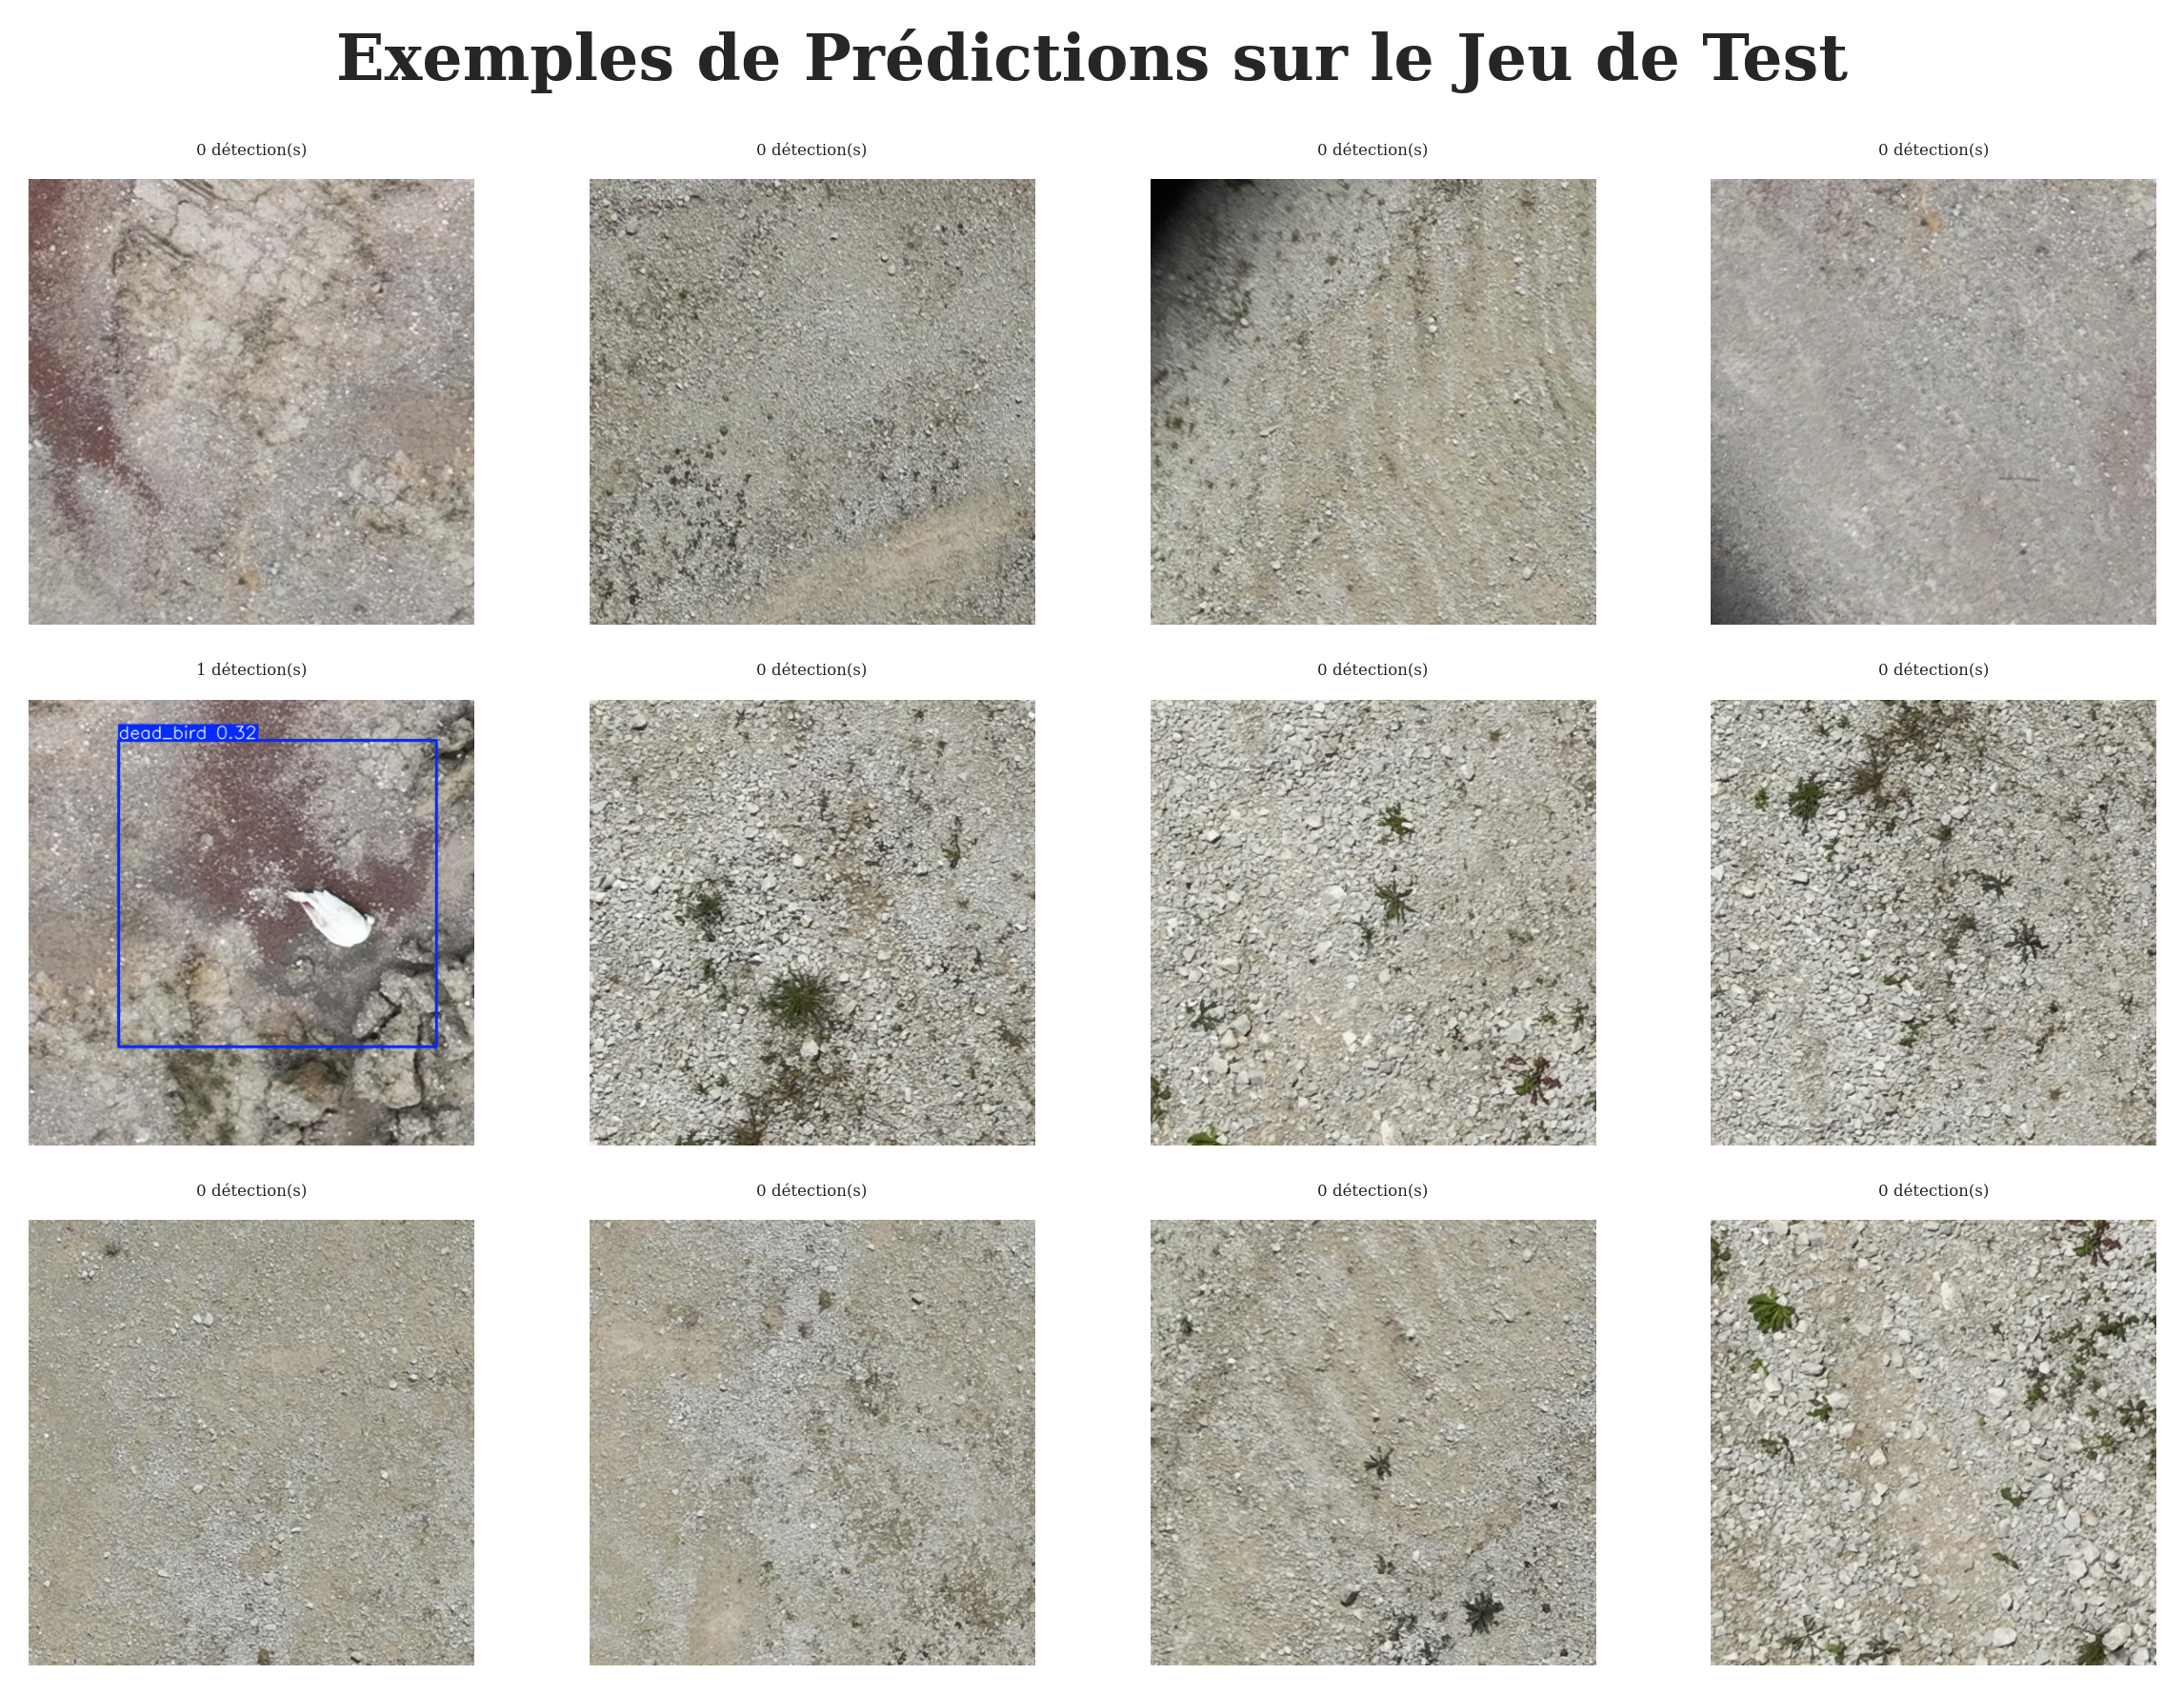

✓ Exemples de prédictions sauvegardés


In [22]:
# Sélectionner quelques images pour visualisation
sample_images = test_images[23:35]  # 12 exemples

fig, axes = plt.subplots(3, 4, figsize=(8, 6))
axes = axes.ravel()

for idx, img_path in enumerate(sample_images):
    # Prédiction
    results_pred = model.predict(source=str(img_path), conf=0.25, verbose=False)[0]

    # Obtenir l'image avec les annotations
    img_with_boxes = results_pred.plot()
    img_rgb = cv2.cvtColor(img_with_boxes, cv2.COLOR_BGR2RGB)

    axes[idx].imshow(img_rgb)
    axes[idx].axis('off')

    # Titre avec nombre de détections
    num_det = len(results_pred.boxes)
    axes[idx].set_title(f"{num_det} détection(s)", fontsize=4)

plt.suptitle('Exemples de Prédictions sur le Jeu de Test', fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout()
plt.savefig(results_dir / 'prediction_examples.png', bbox_inches='tight')
plt.show()
print("✓ Exemples de prédictions sauvegardés")

## 11. Sauvegarde d’exemples représentatifs

In [23]:
def calculate_iou(box1, box2):
    """Calcule l'IoU entre deux bounding boxes"""
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])

    intersection = max(0, x2 - x1) * max(0, y2 - y1)
    area1 = (box1[2] - box1[0]) * (box1[3] - box1[1])
    area2 = (box2[2] - box2[0]) * (box2[3] - box2[1])
    union = area1 + area2 - intersection

    return intersection / union if union > 0 else 0

def classify_detections(pred_boxes, gt_boxes, iou_threshold=0.5):
    """Classe les détections en TP, FP, FN"""
    matched_gt = set()
    tp, fp, fn = [], [], []

    # Pour chaque prédiction
    for i, pred in enumerate(pred_boxes):
        matched = False
        for j, gt in enumerate(gt_boxes):
            if j not in matched_gt:
                iou = calculate_iou(pred['bbox'], gt['bbox'])
                if iou >= iou_threshold:
                    tp.append(pred)
                    matched_gt.add(j)
                    matched = True
                    break

        if not matched:
            fp.append(pred)

    # Les ground truth non matchés sont des faux négatifs
    for j, gt in enumerate(gt_boxes):
        if j not in matched_gt:
            fn.append(gt)

    return tp, fp, fn

In [24]:
def compute_iou(box1, box2):
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])

    inter = max(0, x2 - x1) * max(0, y2 - y1)
    area1 = (box1[2]-box1[0]) * (box1[3]-box1[1])
    area2 = (box2[2]-box2[0]) * (box2[3]-box2[1])

    union = area1 + area2 - inter
    return inter / union if union > 0 else 0
image_dir = "/content/drive/MyDrive/projet_PIC/final_merged_dataset_v4/test/images"
label_dir = "/content/drive/MyDrive/projet_PIC/final_merged_dataset_v4/test/labels"

save_dir = "visual_results"
os.makedirs(save_dir, exist_ok=True)

In [25]:
def draw_box(img, box, color, text=None):
    x1, y1, x2, y2 = map(int, box)
    cv2.rectangle(img, (x1,y1), (x2,y2), color, 2)
    if text:
        cv2.putText(img, text, (x1, y1-5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)


In [26]:
TP, FP, FN, IMP = [], [], [], []

for img_name in os.listdir(image_dir):
    img_path = os.path.join(image_dir, img_name)
    label_path = os.path.join(label_dir, img_name.replace(".jpg", ".txt"))

    img = cv2.imread(img_path)
    h, w, _ = img.shape
    vis_img = img.copy()

    # ---------- GT ----------
    gt_boxes = []
    if os.path.exists(label_path):
        with open(label_path) as f:
            for line in f:
                _, xc, yc, bw, bh = map(float, line.split())
                x1 = int((xc - bw/2) * w)
                y1 = int((yc - bh/2) * h)
                x2 = int((xc + bw/2) * w)
                y2 = int((yc + bh/2) * h)
                gt_boxes.append([x1,y1,x2,y2])

    # ---------- PRED ----------
    results = model(img_path, conf=0.2)[0]
    pred_boxes = results.boxes.xyxy.cpu().numpy() if results.boxes else []
    scores = results.boxes.conf.cpu().numpy() if results.boxes else []

    matched_gt = set()
    status_img = None

    # draw GT first
    for gb in gt_boxes:
        draw_box(vis_img, gb, (0,255,0), "GT")

    for pb, sc in zip(pred_boxes, scores):
        best_iou = 0
        best_gt = -1

        for i, gb in enumerate(gt_boxes):
            iou = compute_iou(pb, gb)
            if iou > best_iou:
                best_iou = iou
                best_gt = i

        if best_iou > 0.5:
            color = (255,0,0)
            TP.append(img_path)
            label = f"Pred TP {sc:.2f}"
            status_img = "TP"

        elif best_iou > 0.2:
            color = (0,165,255)
            IMP.append(img_path)
            label = f"Pred IMP {sc:.2f}"
            status_img = "IMPRECISE"

        else:
            color = (0,0,255)
            FP.append(img_path)
            label = f"Pred FP {sc:.2f}"
            status_img = "FP"

        draw_box(vis_img, pb, color, label)

        if best_gt >= 0:
            matched_gt.add(best_gt)

    for i in range(len(gt_boxes)):
        if i not in matched_gt:
            FN.append(img_path)
            status_img = "FN"

    if status_img:
        os.makedirs(f"{save_dir}/{status_img}", exist_ok=True)
        cv2.imwrite(f"{save_dir}/{status_img}/{img_name}", vis_img)


In [27]:
def save_examples(lst, name, n=3):
    os.makedirs(f"{save_dir}/{name}", exist_ok=True)
    for i, p in enumerate(lst[:n]):
        img = cv2.imread(p)
        cv2.imwrite(f"{save_dir}/{name}/{i}.jpg", img)

save_examples(TP, "TP")
save_examples(FP, "FP")
save_examples(FN, "FN")
save_examples(IMP, "IMPRECISE")
